In [1]:
# -*- coding: utf-8 -*-
from matplotlib import pyplot as plt
from pathlib import Path
import torch
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
from src.utils.data_modules import RoadDataset
from src.utils.train_modules import TrainEpoch,ValidEpoch
from src.utils.augmentations import get_augmentation
from src.visualization import visualize
import pathlib
import segmentation_models_pytorch as smp
import os
from torch.utils.data import Dataset,DataLoader
import numpy as np
import random

In [2]:
import torch
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
def preprocess_mask(mask):
    "This function takes a mask and converts it to a uint8 and float32,"
    "then sets the bits that are 1.0 and 0.0, respectively."
    mask=(mask>0).astype(np.uint8)*255
    mask = mask.astype(np.float32)
    mask[mask == 255.0] = 1.0
    mask[mask == 0.0]= 0.0
    return mask
class RoadDataset(Dataset):
    """Construct Torch dataset
    Args:
        data_path [str]:      (callbale): path_to raw data
        split [str]:          train or test split
        test_split [float]:   ratio of split between test and train
        step_factor [float]:  step_factor<1 -> not using whole dataset only percentage of if
                              step_factor>1 -> reusing same datasample in one epoch but differently augmented
        transform [str]:      Augmentation policy from albumentations
        external  [str]:      To use external data not provided by competition: deepglobe,massachussets,epfl
        seed [int]:           make it reproduciple

    Return:
        transform: albumentations.Compose

    """
    def __init__(self,
                 data_path,
                 split,
                 test_split=0.15,
                 preprocess=None,
                 step_factor=None,
                 transform=None,
                 external_deep=None,
                 external_massa=None,
                 external_epfl=None,
                 external_roadtracer=None,
                 seed = 42,
    ):
        self.data_path=data_path
        self.images_directory = data_path+"/raw/training/images/"
        self.masks_directory = data_path+"/raw/training/groundtruth/"
        self.external_roadtracer = external_roadtracer
        self.test_split = test_split
        self.seed = seed
        self.split = split
        self.transform = transform
        self.preprocess = preprocess
        self.step_factor=step_factor
        self.externals=[external_deep,external_massa,external_epfl,external_roadtracer]
        self.external_strings=["deepglobe","massachusetts","epfl","roadtracing"]
        
        
        #Get Raw Data filenmaes
        file_names = self.__raw_data__()
        #External DATA
        for external_bool, external_string in zip(self.externals,self.external_strings):
            if external_bool:
                file_names = self.__external_data__(external_string,file_names)
        self.images_filenames = file_names

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = cv2.imread(image_filename)
        mask = cv2.imread(image_filename.replace("images","groundtruth"), cv2.IMREAD_UNCHANGED)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = preprocess_mask(mask)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        # apply preprocessing
        if self.preprocess is not None:
            sample = self.preprocess(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        else:
            tensors = self.to_tensor()(image=image,mask=mask)
            image = tensors["image"]
            mask =  tensors["mask"]
        image = image.type(torch.float32)
        mask = mask.type(torch.float32)
        if len(mask.size())==2:
            mask = torch.unsqueeze(mask, 0)
        return image, mask
    
    def __raw_data__(self):
        #Get filenames from main raw directory
        internal_fns = list(sorted(os.listdir(self.images_directory)))
        internal_fns = [os.path.join(self.images_directory, i) for i in internal_fns if
                                    cv2.imread(os.path.join(self.images_directory, i)) is not None]
        
        random.seed(self.seed)
        random.shuffle(internal_fns)
        train_fns = internal_fns[0:np.int32((1 - self.test_split) * len(internal_fns))]
        val_fns = internal_fns[np.int32((1 - self.test_split) * len(internal_fns)):-1]

        if self.split =="train":
            fns=[]
            if self.step_factor>1:
                temp_filenames = list(train_fns)
                for i in range(int(self.step_factor)):
                    for element in temp_filenames:
                        fns.append(element)
            else:
                fns = train_fns[0:int(len(train_fns)*self.step_factor)]
        else:
            fns=val_fns
        return fns
    def __external_data__(self,data_name,fns):
        data_path = self.data_path + f"/external/{data_name}/"
        images_directory_external = data_path + "processed/images/"
        external_fns = list(sorted(os.listdir(images_directory_external)))
        external_fns = [os.path.join(images_directory_external, i) for i in external_fns if
                                    cv2.imread(os.path.join(images_directory_external, i)) is not None]
        
        random.seed(self.seed)
        random.shuffle(external_fns)
        fns.extend(external_fns)
        random.shuffle(fns)
        return fns
    def to_tensor(self):
        _transform = [
            ToTensorV2()
            ]
        return A.Compose(_transform)
        
        



In [4]:
working_path = pathlib.Path().resolve()
path_object = pathlib.Path(working_path)
parent_path = path_object.parent
data_path = os.path.join(parent_path, "data/")
import os
import warnings
warnings.filterwarnings("ignore")
import cv2
import numpy as np
import torch
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset,DataLoader
cudnn.benchmark = True
import random
import albumentations as A
from albumentations.pytorch import ToTensorV2
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')

In [5]:
working_path = pathlib.Path().resolve()
path_object = pathlib.Path(working_path)
parent_path = path_object.parent
data_path = os.path.join(parent_path, "data/")
train_dataset = RoadDataset(data_path,
                            split="train",
                            transform=get_augmentation(augmentation="Combine5",img_size=416),
                            step_factor=2,
                            test_split=0.15,
                            seed=42,
                            preprocess=None,
                            external_roadtracer=False,
                            external_deep=True,
                            external_epfl=True,
                            )
valid_dataset = RoadDataset(data_path,
                            split="val",
                            transform=get_augmentation(augmentation="Validation",img_size=416),
                            step_factor=1,
                            test_split=0.15,
                            seed=42,
                            )
train_loader = DataLoader(train_dataset,
                          batch_size=16,
                          shuffle=True,
                          num_workers=0,
                          pin_memory=True)
valid_loader = DataLoader(valid_dataset,
                          batch_size=16,
                          shuffle=True,
                          num_workers=0,
                          pin_memory=True)

In [4]:
valid_images,valid_masks = next(iter(valid_loader))
valid_images = valid_images.permute(0,2,3,1).numpy().astype(np.uint8)
valid_masks = valid_masks.numpy()
valid_masks = valid_masks.reshape(valid_masks.shape[0],valid_masks.shape[2],valid_masks.shape[3])

In [14]:
masks = []
images = []
for image,mask in train_dataset:
    masks.append(mask.numpy())

In [15]:
from collections import Counter


In [16]:
Counter(np.array(masks).flatten().tolist())

Counter({0.0: 466468953, 1.0: 89040807})

In [17]:
466468953+89040807

555509760

In [18]:
466468953/555509760

0.8397133346496019

(16, 1, 416, 416)


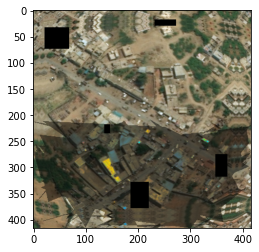

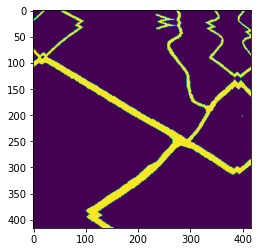

In [84]:
#Just use CTRL-Enter, Augmentation are defined in RoadDataset 
train_images,train_masks = next(iter(train_loader))
train_images = train_images.permute(0,2,3,1).numpy().astype(np.uint8)
train_masks = train_masks.numpy()
print(train_masks.shape)
plt.imshow(train_images[0])
plt.show()
plt.imshow(train_masks[0].reshape(train_masks[0].shape[1],train_masks[0].shape[2]))


In [14]:
def custom_aug_mask(mask,max_value=8,**kwargs):
    mask = morphology.binary_dilation(mask,morphology.selem.disk(max_value))
    return morphology.binary_erosion(mask,morphology.selem.disk(max_value)).astype(np.float32)

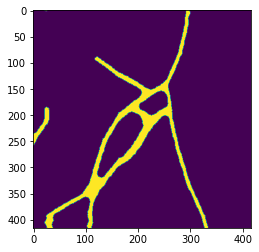

In [24]:
from skimage import morphology
a = train_masks[7].reshape(train_masks[0].shape[1],train_masks[0].shape[2])
b = custom_aug_mask(a,max_value=8)
plt.imshow(a)
plt.show()
plt.imshow(b)
plt.show()

In [48]:
from collections import Counter
Counter(a.flatten().tolist())

Counter({0.0: 156339, 1.0: 16717})

In [ ]:
#Choose any of the augmentation polycies or write your own
transform = get_augmentation(augmentation="Autoalbument2",img_size=416)
transformed= transform(image=valid_images[0],mask=valid_masks[0])
plt.imshow(transformed["image"])
plt.show()
plt.imshow(transformed["mask"])

In [ ]:
#Differentiable Skeletonize
import torch
import torch.nn as nn
import torch.nn.functional as F


def soft_erode(img):
    if len(img.shape)==4:
        p1 = -F.max_pool2d(-img, (3,1), (1,1), (1,0))
        p2 = -F.max_pool2d(-img, (1,3), (1,1), (0,1))
        return torch.min(p1,p2)
    elif len(img.shape)==5:
        p1 = -F.max_pool3d(-img,(3,1,1),(1,1,1),(1,0,0))
        p2 = -F.max_pool3d(-img,(1,3,1),(1,1,1),(0,1,0))
        p3 = -F.max_pool3d(-img,(1,1,3),(1,1,1),(0,0,1))
        return torch.min(torch.min(p1, p2), p3)


def soft_dilate(img):
    if len(img.shape)==4:
        return F.max_pool2d(img, (3,3), (1,1), (1,1))
    elif len(img.shape)==5:
        return F.max_pool3d(img,(3,3,3),(1,1,1),(1,1,1))


def soft_open(img):
    return soft_dilate(soft_erode(img))


def soft_skel(img, iter_):
    img1  =  soft_open(img)
    skel  =  F.relu(img-img1)
    for j in range(iter_):
        img  =  soft_erode(img)
        img1  =  soft_open(img)
        delta  =  F.relu(img-img1)
        skel  =  skel +  F.relu(delta-skel*delta)
    return skel

In [ ]:
image,mask=next(iter(train_loader))
skel = soft_skel(mask,20)
m = mask[0].cpu().detach().numpy().reshape(416,416,1)
s = skel[0].cpu().detach().numpy().reshape(416,416,1)
plt.imshow(s)
plt.show()
plt.imshow(m)
plt.show()